# Experiment

## Perequisites

Extract the data to `./metrics`

## Preparations

Import necessary libraries

Idées de mesures:

- distribution des fonctions
- politique basique edge first ou quoi
- temps de deploiement vs nombre de noeuds dans le Fog vs taille du réseau
- temps de deploiement vs nombre de fonctions vs taille du réseau
- la mémoire et le cpu au niveau du noeud fog

graohes des localités : courbe qui montre combien de fonctions se répartissent sur l'edge et sur le cloud
faire varier le nombre de noeuds

Changer le nombre de fonctions que l'on déploi = saturation (x nbre de fonction)
Regarder l'évolution des temps de réponses / des violations de temps de deadline

Regarder si on satisfait les deadlines et si c'est scalable

Comparer en terme de prix = pas relevant
Définir une fonction d'utilité au niveau des enchères, par rapport au temps d'exécution




In [4]:
METRICS_PATH <- c("measures/auction_placement_4", "measures/auction_placement_4_more") # looks at "./*"

In [5]:
packages_to_have <- c('reticulate', 'tidyverse', 'igraph', 'r2r', 'formattable', 'stringr', 'viridis', 'zoo', 'geomtextpath', 'ModelMetrics')

dir.create(Sys.getenv("R_LIBS_USER"), recursive = TRUE)  # create personal library
.libPaths(Sys.getenv("R_LIBS_USER"))  # add to the path

packages = installed.packages()
packages = packages[, "Package"]

if (FALSE %in% (packages_to_have %in% packages)){
    install.packages(packages_to_have)
}

# To call python from R
library(reticulate)
library(tidyverse)
library(igraph)
library(r2r)
library(formattable)
library(stringr)
library(viridis)
library(geomtextpath)
library(zoo) # moving averages
library(ModelMetrics)

theme_set(theme(
        legend.position='bottom',
        legend.direction='vertical',
        panel.background = element_rect(fill = "white"),
        panel.grid = element_blank(),
    ))




Warning message in dir.create(Sys.getenv("R_LIBS_USER"), recursive = TRUE):
“'/home/jovyan/R/x86_64-conda-linux-gnu-library/4.2' already exists”
── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following o

Then, the dependencies

Load the the Python `integration.py` script to use its variable in R

In [6]:
#use_virtualenv('.venv/', required = TRUE)
# Always throws an error because it is a CLI tool; it is not made to be loaded in R
try(source_python("definitions.py"))

Warning message in poetry_config(required_module):
“This project appears to use Poetry for Python dependency management.
However, the 'poetry' command line tool is not available.
reticulate will be unable to activate this project.
Please ensure that 'poetry' is available on the PATH.”


The graph of the network

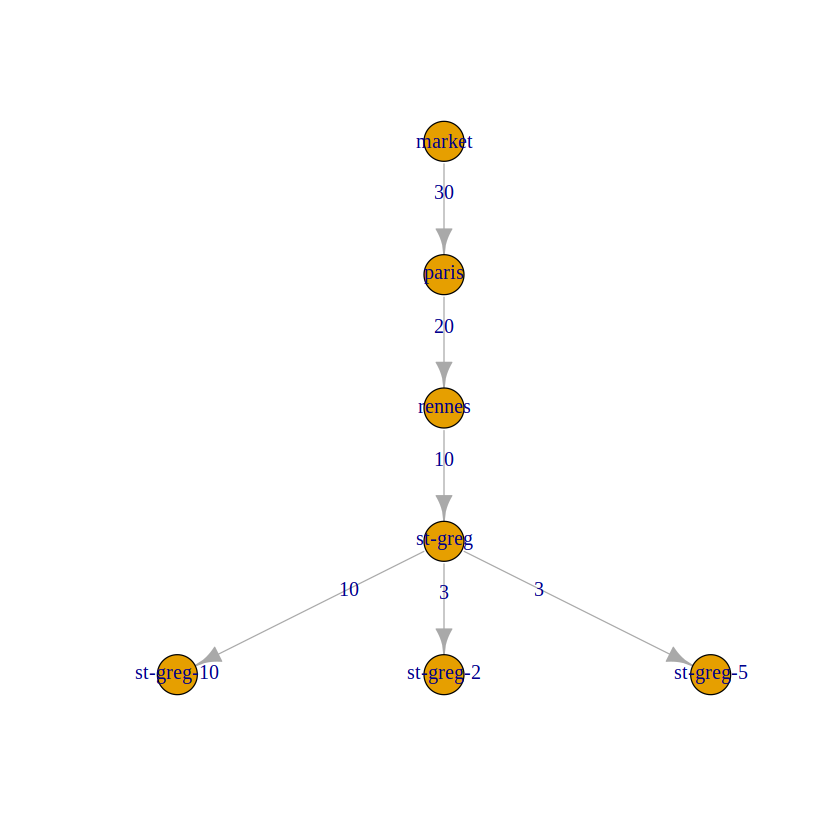

In [7]:
raw <- py$ADJACENCY

adjancy_transform <- function(x) {
  ret <- matrix(0, nrow = length(x), ncol = length(x))
  rownames(ret) <- c(sort(names(x)))
  colnames(ret) <- c(sort(names(x)))
  for (ii in seq_along(x)) {
    for (jj in seq_along(x[[ii]])) {
      ret[names(x)[[ii]], x[[ii]][[jj]][[1]]] <- strtoi(x[[ii]][[jj]][[2]])
    }
  }
  return(ret)
}

graph_matrix <- adjancy_transform(raw)
net <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
plot(net, layout = layout_as_tree, edge.label = E(net)$weight)

# ceb <- cluster_edge_betweenness(g)
#
# dendPlot(ceb, mode="hclust")
# plot(ceb, g)

In [8]:
names_raw <- read.csv2(file = paste(METRICS_PATH[1], "names.csv", sep = "/"), header = TRUE, sep = "\t")
names <- hashmap()
names[names_raw$instance] <- names_raw$name

missing <- data.frame(instance = names_raw$name, n = 0)

Load the names of the node and their correspondance in their IP on the virtual network

In [9]:
load_csv <- function(filename) {
    files <- lapply(METRICS_PATH, \(x) paste(".", x, filename, sep= "/"))
    all_data <- purrr::map_df(files, ~ mutate(read.csv2(.x, header = TRUE, sep = "\t"), folder = basename(dirname(.x))))
    return(all_data)
}

In [10]:
prepare <- function(x) {
  return(
    x %>%
      mutate(instance = names[instance]) %>%
      mutate(instance = as.character(instance)) %>%
      mutate(timestamp_raw = as.numeric(as.character(timestamp))) %>%
      mutate(timestamp = as.POSIXct(timestamp_raw, origin = "1970-01-01")) %>%
      mutate(value = as.numeric(as.character(value))) %>%
      merge(missing, all = TRUE) %>%
      arrange(instance)
  )
}

## Data processing

Check what nodes we have values for (usually the ones who have submitted bids and etc.):
- Green is ok
- Red is a node that was not present in the data

In [11]:
mem <- load_csv("fog_node_memory_available.csv") %>%
    prepare() %>%
    distinct(instance, value, .keep_all = TRUE) %>%
    select(c(instance, value, folder)) %>%
    mutate(dyn = formattable::percent(value / max(value, na.rm = TRUE))) %>%
    mutate(value = as.numeric(as.character(value)))

cpu <- load_csv("fog_node_cpu_used.csv") %>%
    prepare() %>%
    select(c(instance, value, folder)) %>%
    distinct(instance, value, folder, .keep_all = TRUE) %>%
    group_by(instance, folder) %>%
    mutate(value = as.numeric(as.character(value)))

[1] "measures/auction_placement_4"
[1] "measures/auction_placement_4_more"


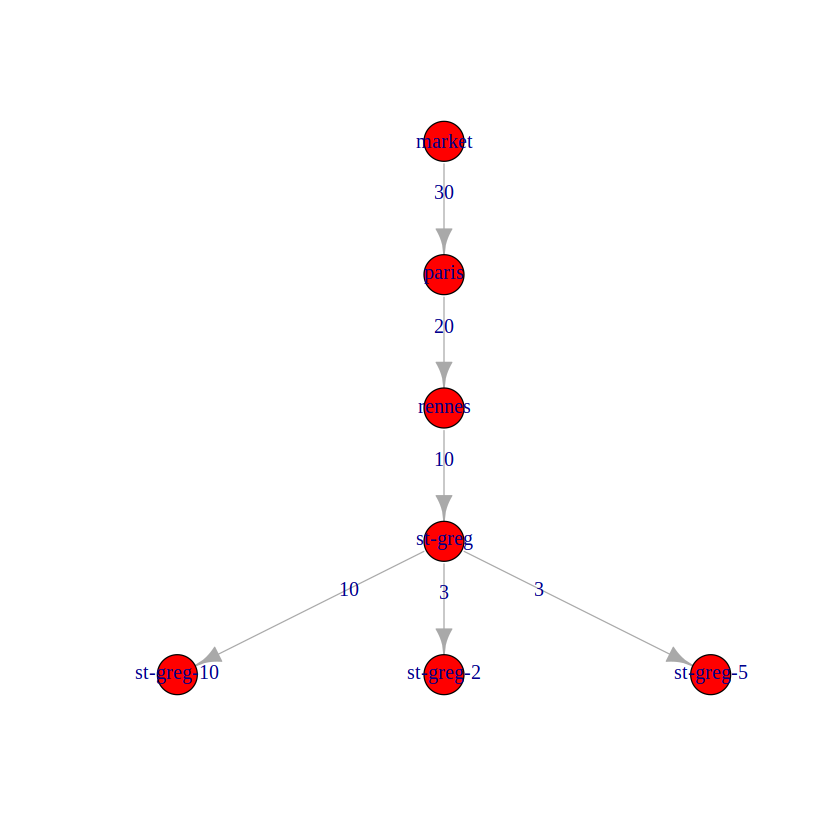

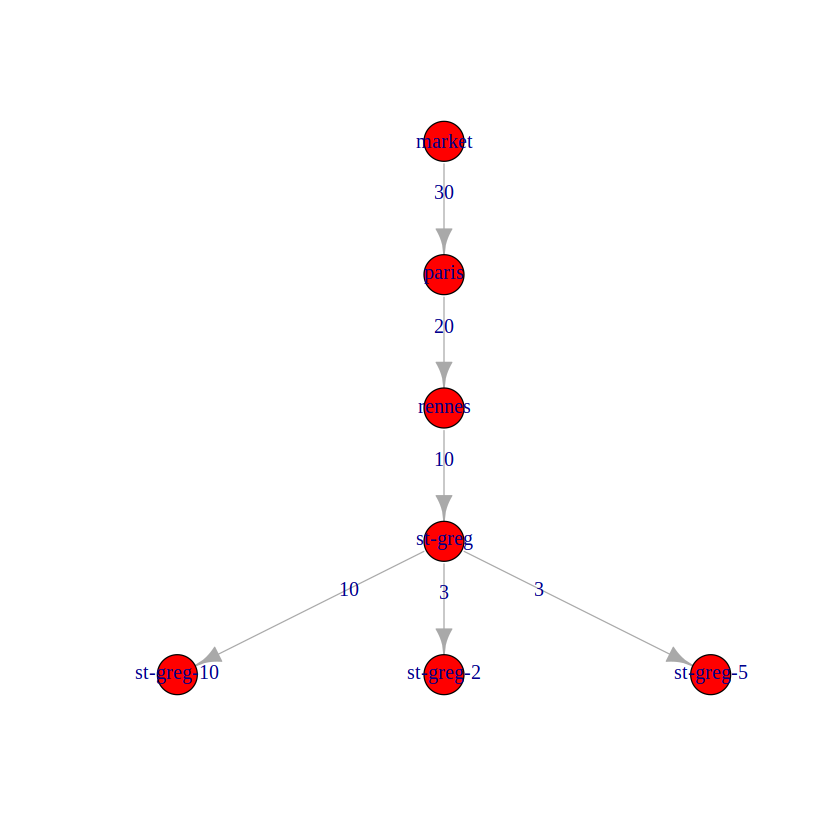

In [12]:
PercentageColourConnected <- function(x) {
    colorRampPalette(c("red", "green"))(2)[ifelse(is.na(x), 1, 2)]
}
for (folder_name in METRICS_PATH){
    print(folder_name)
    net_connected <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
    memory <- mem %>% filter(folder == folder_name) %>% select(instance, value)
    all_zero <- data.frame(instance = names_raw$name, n = 0)
    memory <- memory %>%
      merge(all_zero, all = TRUE) %>%
      group_by(instance) %>%
      summarise(across(everything(), sum)) %>%
      arrange()
    V(net_connected)$color <- PercentageColourConnected(memory$value)
    plot(net_connected, layout = layout_as_tree, edge.label = E(net_connected)$weight)
}


## Distribution of the functions in the network

`summarise()` has grouped output by 'instance'. You can override using the `.groups` argument.


instance   folder                   n 
1  paris      auction_placement_4_more 12
2  rennes     auction_placement_4      22
3  rennes     auction_placement_4_more 12
4  st-greg    auction_placement_4       7
5  st-greg    auction_placement_4_more  9
6  st-greg-10 auction_placement_4       2
7  st-greg-2  auction_placement_4       8
8  st-greg-2  auction_placement_4_more  9
9  st-greg-5  auction_placement_4       8
10 st-greg-5  auction_placement_4_more  5

[1] "measures/auction_placement_4"
# A tibble: 7 × 2
# Groups:   instance [7]
  instance       n
  <chr>      <dbl>
1 market         0
2 paris          0
3 rennes         0
4 st-greg        0
5 st-greg-10     0
6 st-greg-2      0
7 st-greg-5      0
[1] "measures/auction_placement_4_more"
# A tibble: 7 × 2
# Groups:   instance [7]
  instance       n
  <chr>      <dbl>
1 market         0
2 paris          0
3 rennes         0
4 st-greg        0
5 st-greg-10     0
6 st-greg-2      0
7 st-greg-5      0


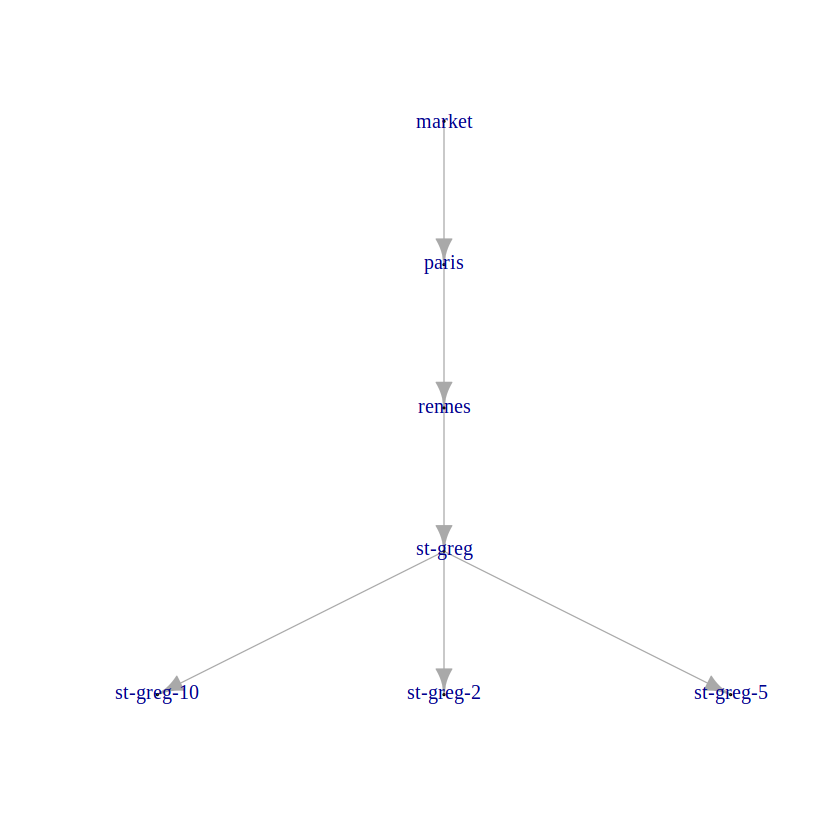

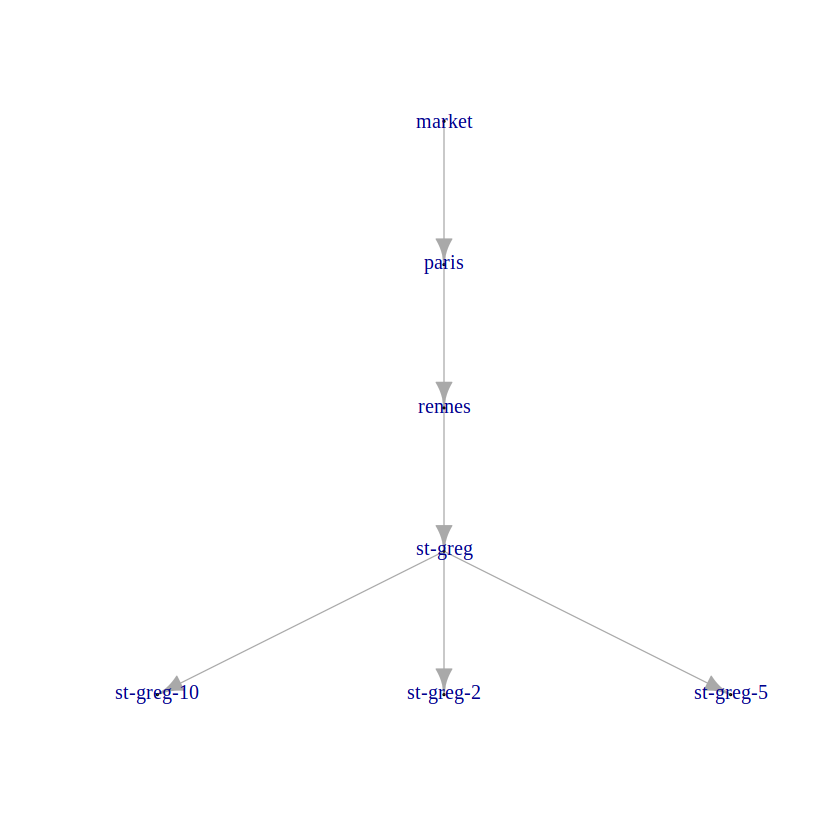

In [13]:
bids_raw <- load_csv("fog_node_bids.csv") %>% prepare()

bids_won_raw <- bids_raw %>%
  select(c(instance, function_name, value, folder))

bids_won <- bids_won_raw %>%
  group_by(function_name, folder) %>%
  slice(which.min(value)) %>%
  group_by(instance, folder) %>%
  summarise(n = n()) %>%
  # group_by(folder ) %>%
  complete(folder,  fill = list(n = 0, instance="tto")) %>%
  
{.}

bids_won


for (folder_name in METRICS_PATH){
    print(folder_name)
    net_won <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
    won <- bids_won %>% filter(folder == folder_name) %>% select(instance, n)
    # Add missing participants and put them at 0
    bids_won_all_zero <- data.frame(instance = names_raw$name, n = 0)
    won <- won %>%
      merge(bids_won_all_zero, all = TRUE) %>%
      group_by(instance) %>% {.}
      # summarise(across(everything(), sum)) %>%
      # arrange()
    print(won)
    V(net_won)$size <- won$n
    plot(net_won, layout = layout_as_tree)
}

Plot the free cpu

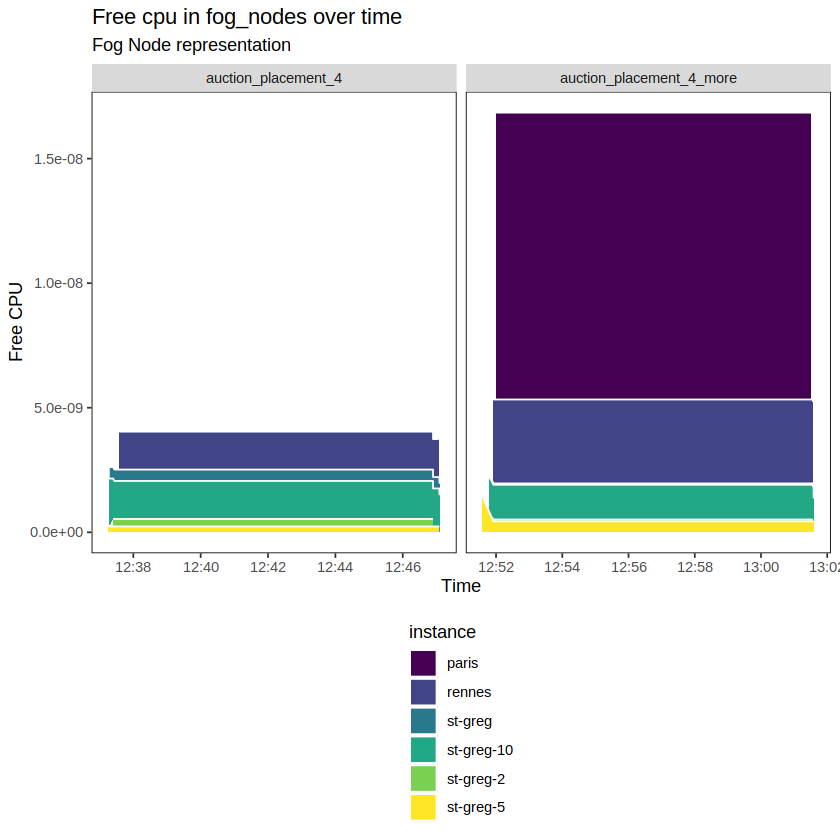

In [14]:
cpu_used <- load_csv("fog_node_cpu_used.csv") %>% prepare()
cpu_avail <- load_csv("fog_node_cpu_available.csv") %>% prepare()

cpu_free <- cpu_used %>%
  inner_join(cpu_avail, by = c("instance", "timestamp", "folder")) %>%
  mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance, folder) %>%
  mutate(free_percent = formattable::percent(free / max(free))) %>%
  select(instance, timestamp, free, free_percent, folder)%>%
  drop_na()

cpu_free %>%
ggplot(aes(x = timestamp, y = free, fill = instance)) +
  geom_area(position = 'stack',  color = "white") +
  labs(x = "Time", 
       y = "Free CPU", 
       title = "Free cpu in fog_nodes over time", 
       subtitle = "Fog Node representation") +
  facet_grid(cols = vars(folder), scale="free") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

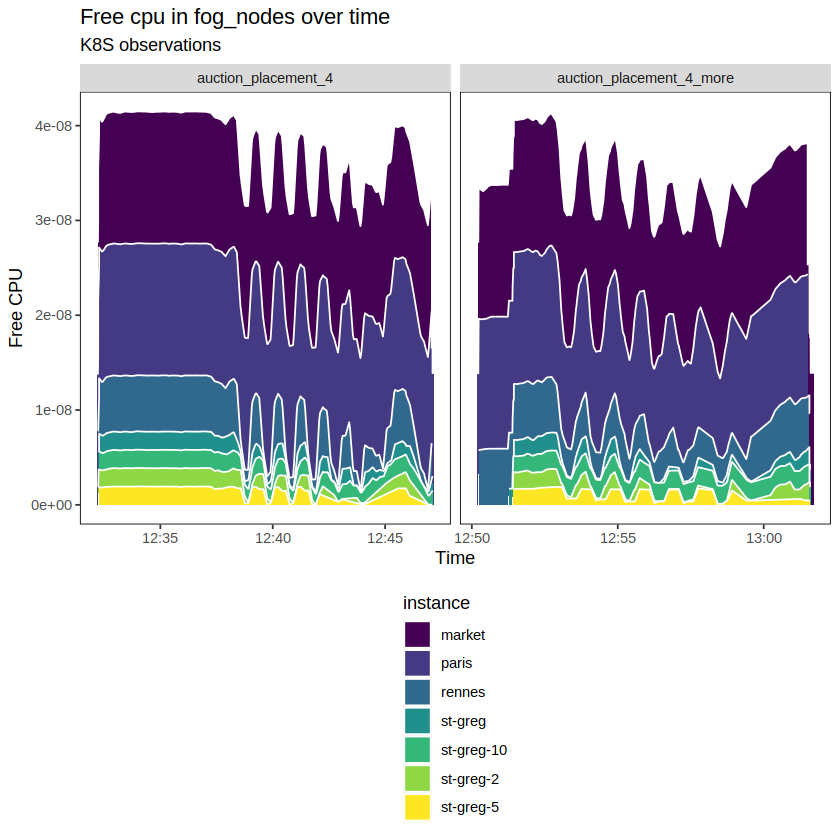

In [15]:
cpu_used <- load_csv("fog_node_cpu_usage.csv") %>% prepare()
cpu_avail <- load_csv("fog_node_cpu_allocatable.csv") %>% prepare()

cpu_free <- cpu_used %>%
  inner_join(cpu_avail, by = c("instance", "timestamp", "folder")) %>%
  mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance, folder) %>%
  mutate(free_percent = formattable::percent(free / max(free))) %>%
  select(instance, timestamp, free, free_percent, folder)%>%
  drop_na()

cpu_free %>%
ggplot(aes(x = timestamp, y = free, fill = instance)) +
  geom_area(position = 'stack',  color = "white") +
  labs(x = "Time", 
       y = "Free CPU", 
       title = "Free cpu in fog_nodes over time", 
       subtitle = "K8S observations") +
  facet_grid(cols = vars(folder), scale="free") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

Plot the free memory

Warning message in max(free, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


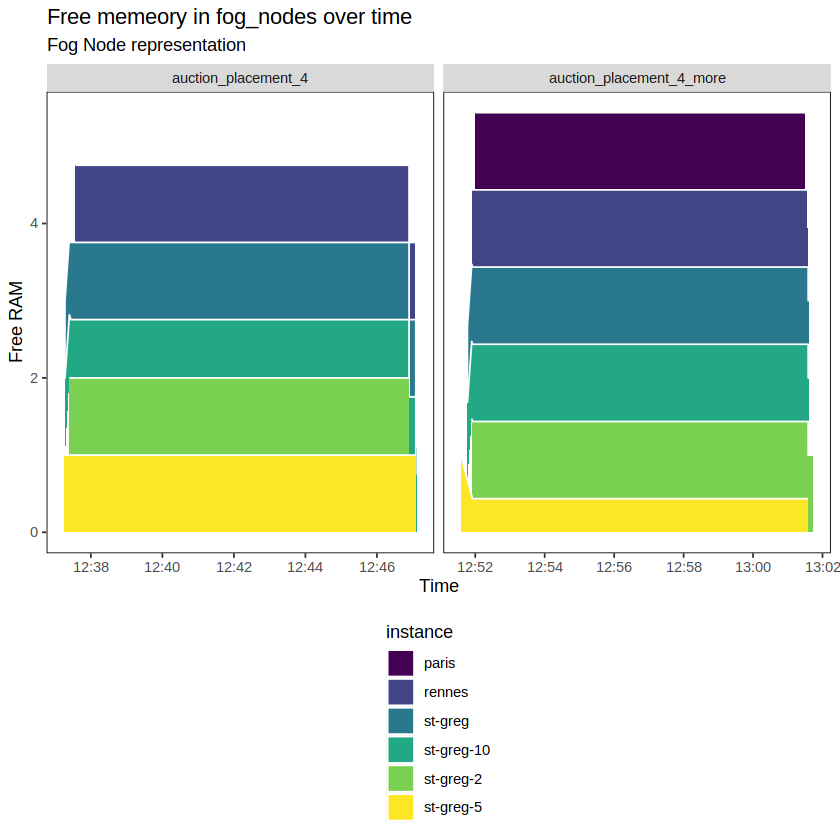

In [16]:
mem_used <- load_csv("fog_node_memory_used.csv") %>% prepare()
mem_avail <- load_csv("fog_node_memory_available.csv") %>% prepare()

mem_free <- mem_used %>%
  inner_join(mem_avail, by = c("instance", "timestamp", "folder")) %>%
mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance, folder) %>%
  mutate(free_percent = formattable::percent(free / max(free, na.rm = TRUE))) %>%
  select(instance, timestamp, free, free_percent, folder) %>%
  drop_na()

mem_free %>%
  ggplot(aes(x = timestamp, y = free_percent, fill = instance)) +
  geom_area(position = 'stack', color = "white") +
  facet_grid(cols = vars(folder), scale="free") +
  labs(x = "Time", 
       y = "Free RAM", 
       title = "Free memeory in fog_nodes over time", 
       subtitle = "Fog Node representation") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

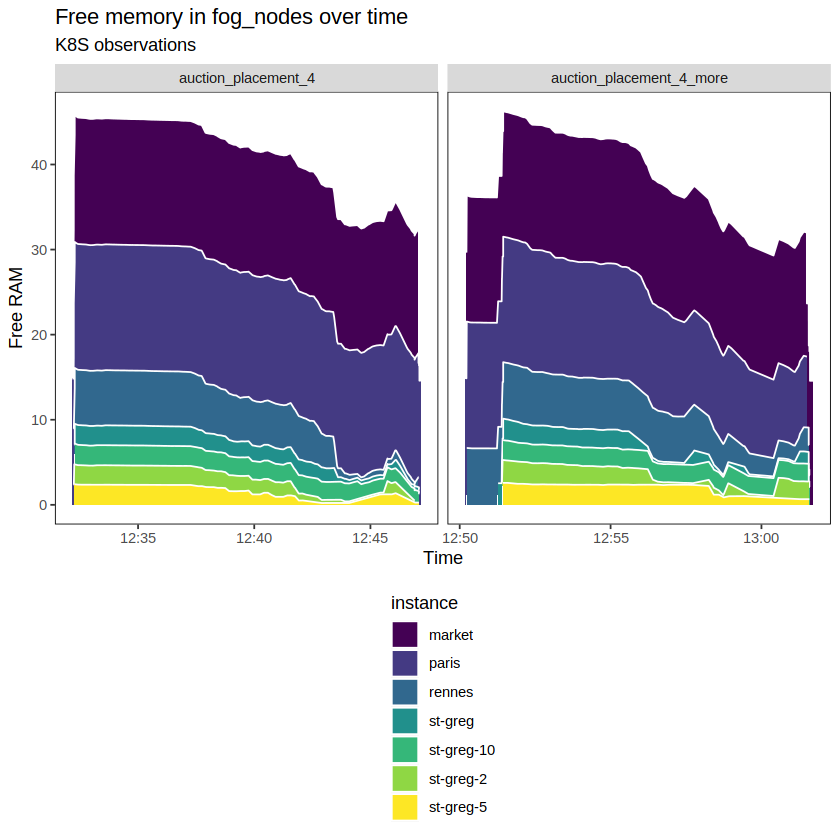

In [17]:
mem_used <- load_csv("fog_node_memory_usage.csv") %>% prepare()
mem_avail <- load_csv("fog_node_memory_allocatable.csv") %>% prepare()

mem_free <- mem_used %>%
  inner_join(mem_avail, by = c("instance", "timestamp", "folder")) %>%
mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance, folder) %>%
  mutate(free_percent = formattable::percent(free / max(free, na.rm = TRUE))) %>%
  select(instance, timestamp, free, free_percent, folder)

mem_free %>%
  ggplot(aes(x = timestamp, y = free, fill = instance)) +
  geom_area(position = 'stack',  color = "white") +
  facet_grid(cols = vars(folder), scale="free") +
  labs(x = "Time", 
       y = "Free RAM", 
       title = "Free memory in fog_nodes over time", 
       subtitle = "K8S observations") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

Latency of the nodes from their rolling average

> It is actually the double of the set latency because first the TCP connection is established and then the data flows. So those are actually: src -> dest and then src -> dest, so counting twice as long as the actual network latency.

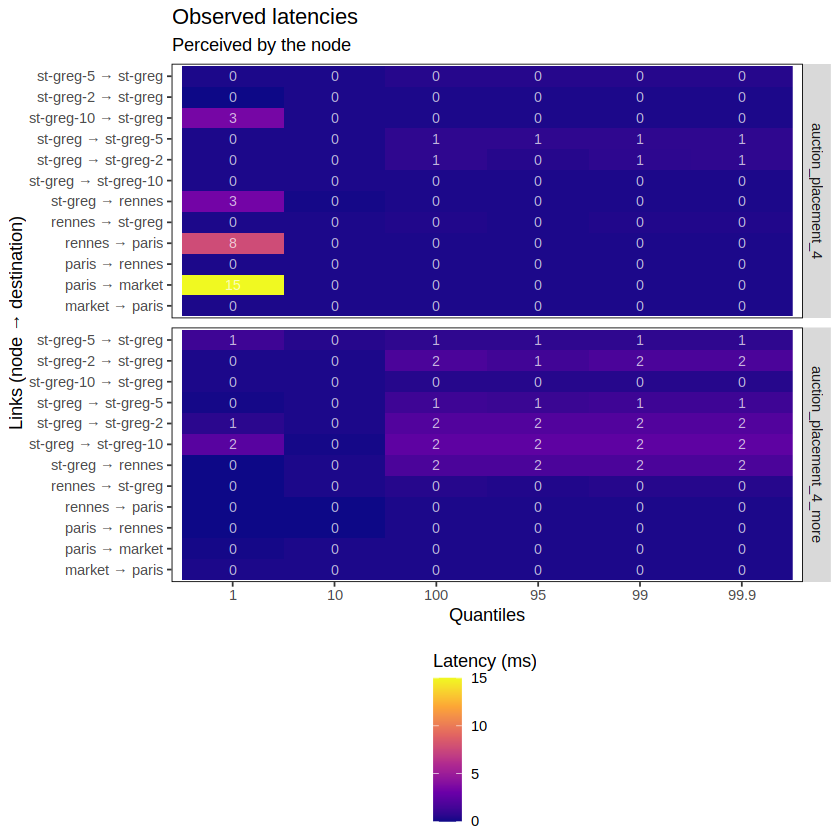

In [89]:
latency <- load_csv("fog_node_neighbors_latency_rolling_avg.csv") %>%
  prepare() %>%
  mutate(instance_to = as.character(names[instance_to]))

p <- c(.01, .1, 0.95, 0.99, 0.999, 1)
p_names <- map_chr(p, ~paste0(.x*100, ""))
p_funs <- map(p, ~partial(quantile, probs = .x, na.rm = TRUE)) %>% 
  set_names(nm = p_names)

quantiles <- latency %>%
    mutate(value = value*1000) %>%
    group_by(instance, instance_to, folder) %>%
    summarize_at(vars(value), funs(!!!p_funs)) %>%
    pivot_longer(cols = -c("instance", "instance_to", "folder"), names_to = c("quantile")) %>%
    mutate(diff = abs(value - max(graph_matrix[instance, instance_to], graph_matrix[instance_to, instance]))) %>%
    {.}
# quantiles

quantiles %>%
    ggplot(
      aes(
        y = factor(str_replace(interaction(instance, instance_to), '\\.', ' → '), ordered = TRUE),
        x = quantile,
        fill = diff,
      )
    ) +
    geom_raster() +
    geom_text(aes(label=round(diff)), color = "white", alpha=.7, size = 3) +
    scale_fill_viridis_c(option = "plasma") +
    # scale_fill_gradient2(low = "black", high = "white") +
    facet_grid(rows = vars(folder), scale="free") +
    labs(
      x = "Quantiles",
      y = "Links (node → destination)",
      title = "Observed latencies",
      subtitle = "Perceived by the node",
      fill = "Latency (ms)"
    )


## Bids

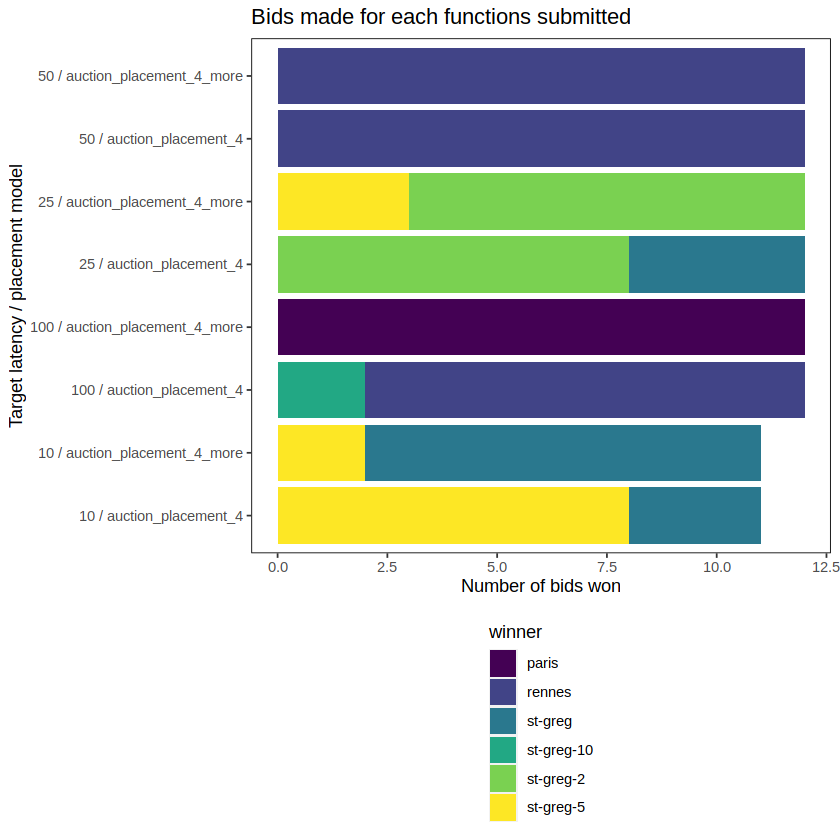

In [19]:
bids_won_function <- bids_raw %>%
  group_by(function_name, folder) %>%
  slice(which.min(value)) %>%
  mutate(winner = instance)

# head(bids_won_function)

bids_function <- bids_raw %>%
  mutate(winner = instance) %>%
  select(instance, function_name, value, folder) %>%
  distinct() %>%
  mutate(latency = stringr::str_match(function_name, "(.+)--(.+)--([0-9]+)--([0-9]+)--([0-9]+)") %>% .[, 4]) %>%
  inner_join(bids_won_function, by = c("function_name", "folder"))

# head(bids_function)

bids_function %>%
    group_by(winner, latency, function_name, folder) %>%
    arrange(desc(as.numeric(latency))) %>%   
    select(winner, latency, function_name, folder) %>%
    distinct() %>%
    ggplot(
      aes(
        x = factor(str_replace(interaction(latency, folder), '\\.', ' / '), ordered = TRUE),
        fill = winner,
      )
    ) +
  geom_bar() +
  coord_flip() +
  labs(x = "Target latency / placement model",
       y = "Number of bids won", 
       title = "Bids made for each functions submitted", 
       color = "Winner node")+
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

`summarise()` has grouped output by 'winner'. You can override using the `.groups` argument.


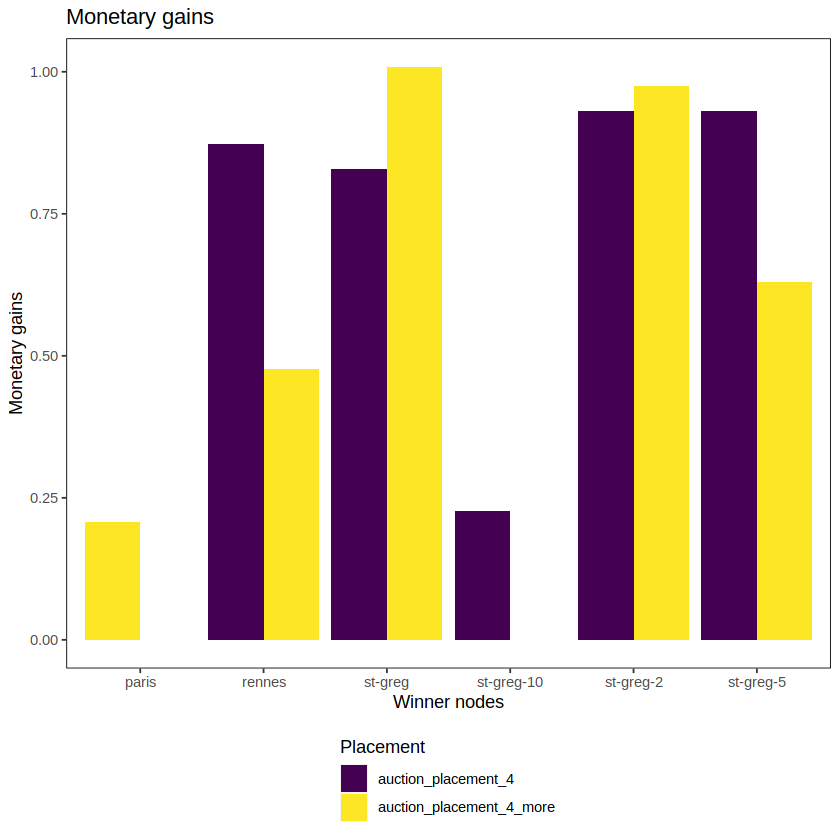

In [20]:
winner_gains <- bids_won_function %>%
  select(winner, function_name, value, folder) %>%
  distinct() %>%
  group_by(winner, folder) %>%
  summarise(total = sum(value))

# head(winner_gains)

winner_gains %>%
  ggplot(aes(x = winner, y = total, fill = folder)) +
  geom_col(position = position_dodge(preserve = 'single')) +
  labs(x = "Winner nodes", y = "Monetary gains", title = "Monetary gains", fill = "Placement")+
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) +
  theme(
        legend.position='bottom',
        legend.direction='vertical',
    )

## Latencies and SLAs

In [21]:
echo_sum <-
  load_csv("echo_function_http_request_to_processing_echo_duration_seconds_print_sum.csv") %>%
  prepare()

echo_count <-
  load_csv("echo_function_http_request_to_processing_echo_duration_seconds_print_count.csv") %>%
  prepare()

latencies <- echo_sum %>%
  mutate(latency = stringr::str_match(tag, "(.+)--(.+)--([0-9]+)--([0-9]+)--([0-9]+)") %>% .[,4]) %>%
  select(latency, folder) %>%
  distinct() %>%
  filter(!is.na(latency))

In [22]:
average <- echo_sum %>%
  inner_join(echo_count,
             by = c("instance", "job", "timestamp", "timestamp_raw", "tag", "period", "folder"),
  ) %>%
  mutate(function_name = tag) %>%
  inner_join(bids_won_function %>% select(function_name, winner, folder) %>% distinct(), by = c("function_name", "folder")) %>%
  select(instance, job, timestamp, function_name, period, value.x, value.y, winner, folder) %>%
  drop_na() %>%
  group_by(instance, job, function_name, period, folder) %>%
   arrange(timestamp, instance, job, function_name, period, folder,
        desc(timestamp)
    ) %>%
  mutate(diff_x = value.x - dplyr::lag(value.x, order_by = timestamp))%>%
  mutate(diff_y = value.y - dplyr::lag(value.y, order_by = timestamp))%>%
  mutate(new_avg = diff_x  / diff_y) %>%
  drop_na() %>%
  mutate(latency = stringr::str_match(function_name, "(.+)--(.+)--([0-9]+)--([0-9]+)--([0-9]+)") %>% .[,4]) %>%
  mutate(index = stringr::str_match(function_name, "(.+)--(.+)--([0-9]+)--([0-9]+)--([0-9]+)") %>% .[,3]) %>%
  mutate(break_sla = new_avg >= as.numeric(latency) / 1000)

p <- c(0.95, 0.99, 0.999, 1)
p_names <- map_chr(p, ~paste0(.x*100, ""))
p_funs <- map(p, ~partial(quantile, probs = .x, na.rm = TRUE)) %>% 
  set_names(nm = p_names)

quantiles <- average %>%
    # mutate(period = as.character(period)) %>%
    group_by(latency, period, folder) %>%
    # select(latency, period, new_avg)  %>%
    summarize_at(vars(new_avg), funs(!!!p_funs)) %>%
    pivot_longer(cols = -c("latency", "period", "folder"), names_to = c("quantile"))

quantiles <- within(quantiles, 
                   latency <- factor(latency, 
                                      levels=names(sort(table(as.numeric(latency)), 
                                                        decreasing=TRUE))))
quantiles <- within(quantiles, 
                   quantile <- factor(quantile, 
                                      levels=names(sort(table(as.numeric(quantile)), 
                                                        decreasing=TRUE))))
# head(quantiles)

# print(
#   quantiles %>%
#     ggplot(
#       aes(
#         x = latency,
#         y = value,
#         fill = quantile,
#         label = round(value, 3),
#       )
#     ) +
#     theme_bw() +
#     geom_col(position="dodge") +
#     coord_flip() +
#     scale_y_continuous(trans='sqrt') + 
#     geom_text(vjust = -0.2, position=position_dodge(width=0.9), size=2.5) +
#     labs(
#       x = "Targeted latencies (ms)",
#       y = "Avg observed lat. (s) by quantiles",
#       title = "Latency between edge and the function.",
#       subtitle = paste("Color maches the quantile")
#     ) +
#     facet_grid(rows = vars(factor(period, stringr::str_sort(unique(period), numeric = TRUE)))) +
#     geom_hline(data=latencies, aes(yintercept=as.numeric(latency)/1000), colour="red") + 
#     scale_color_viridis(discrete = TRUE, option = "D") +
#     scale_fill_viridis(discrete = TRUE)
# )

`summarise()` has grouped output by 'latency', 'n'. You can override using the `.groups` argument.
Adding missing grouping variables: `n`
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 24 rows containing non-finite values (`stat_ecdf()`).”
Warning message:
“Removed 182 rows containing missing values (`geom_step()`).”


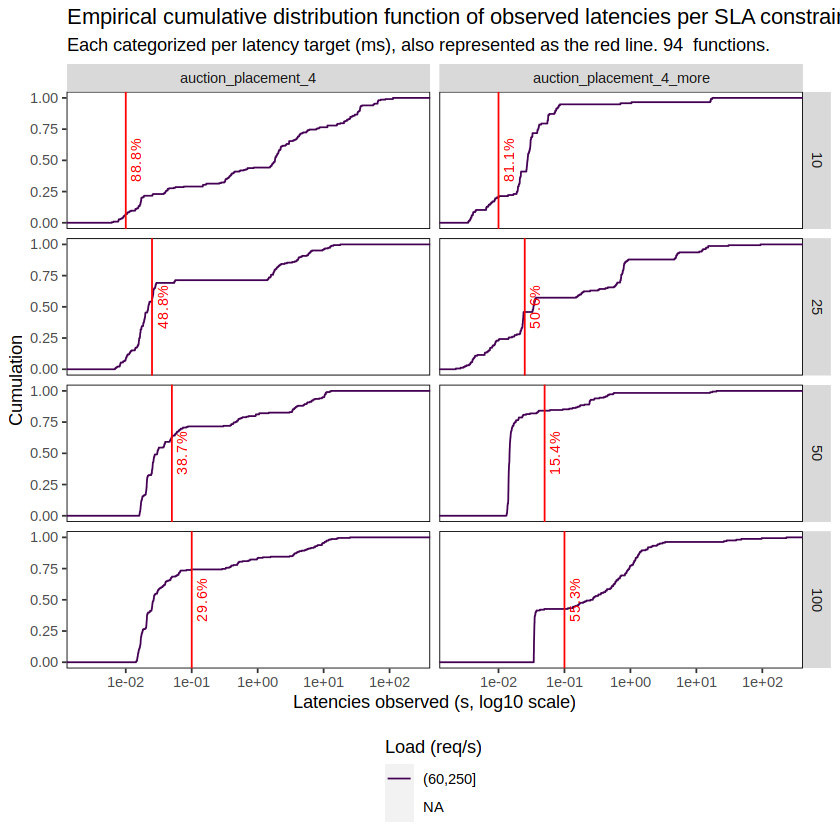

In [23]:
# dataLine <- average %>%
#   select(latency) %>%
#   summarize(mean_x = mean(Sepal.Length))
nb_functions <- average %>%
    group_by(function_name, folder) %>%
    select(function_name, folder) %>%
    distinct() %>%
    {.}

sla_breaks <- average %>%
    group_by(latency, folder) %>%
    select(latency, break_sla, folder) %>%
    group_by(latency, folder) %>%
    add_count() %>%
    group_by(latency, n, folder) %>%
    summarize(broken = sum(break_sla, na.rm=TRUE), total = n()) %>%
    mutate(percent_broken = broken / n) %>%
    {.}

nb_func <- nb_functions %>% group_by(folder) %>% summarise(n = n()) %>% select(n) %>% distinct()

average_with_load <- average %>%
    # mutate(load =  nb_func$n * 1000 / as.numeric(period)) %>%
    # mutate(load_cat = cut(load, breaks = c(0,2000, 4000, 100000))) %>%
    mutate(load =  1000 / as.numeric(period)) %>%
    mutate(load_cat = cut(load, breaks = c(0,40, 60, 250))) %>%
    {.}

latencies_plus_broken <- latencies %>% inner_join(sla_breaks %>% select(latency, percent_broken, folder), by=c('latency', 'folder'))

print(
  average_with_load %>%
    ggplot(
      aes(
        new_avg,
        # group = vars(period),
        color = factor(load_cat),
        # y = new_avg
        # label = scales::percent(percent_per_winner)
      )
    ) +
    stat_ecdf() +
    scale_x_continuous(trans="log10") +
    labs(
      x = "Latencies observed (s, log10 scale)",
      y = "Cumulation",
      title = "Empirical cumulative distribution function of observed latencies per SLA constraints",
      subtitle = paste("Each categorized per latency target (ms), also represented as the red line.", nrow(nb_functions), " functions."),
      color = "Load (req/s)"
    ) +
    facet_grid(rows = vars(factor(latency, stringr::str_sort(unique(latency), numeric = TRUE))), cols = vars(factor(folder))) +
    geom_textvline(data=latencies_plus_broken, aes(xintercept=as.numeric(latency)/1000, label = scales::percent(percent_broken)), colour="red",  vjust = 1.3, size = 3) + 
    scale_color_viridis(discrete = TRUE, option = "D") +
    scale_fill_viridis(discrete = TRUE)
)


Adding missing grouping variables: `instance`, `job`, `function_name`, `period`
`summarise()` has grouped output by 'latency', 'load_cat', 'n'. You can override using the `.groups` argument.
Warning message in geom_rug(side = "l", color = "black"):
“Ignoring unknown parameters: `side`”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 24 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 24 rows containing non-finite valu

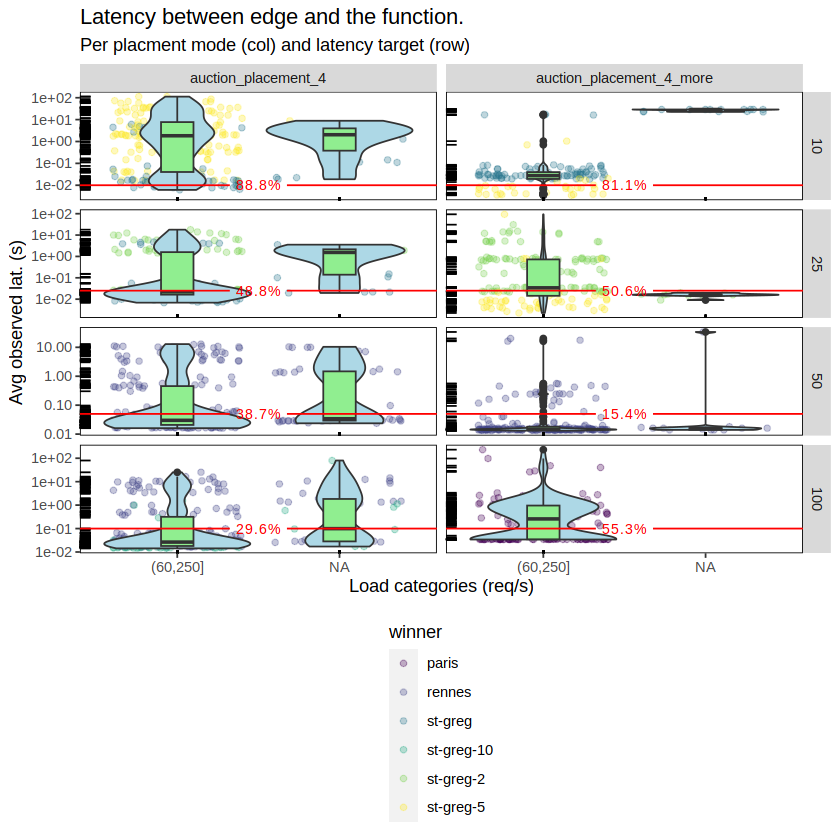

In [24]:
sla_breaks <- average_with_load %>%
    select(latency, load_cat, winner, break_sla, folder) %>%
    group_by(latency, folder) %>%
    add_count() %>%
    group_by(latency,load_cat, n, folder) %>%
    summarize(broken = sum(break_sla, na.rm=TRUE), total = n()) %>%
    mutate(percent = broken / n) %>%
    {.}

sla_breaks <- within(sla_breaks, 
                   latency <- factor(latency, 
                                      levels=names(sort(table(as.numeric(latency)), 
                                                        decreasing=TRUE))))

# head(sla_breaks)

print(
  average_with_load %>%
    group_by(latency) %>%
    arrange(desc(as.numeric(latency))) %>%
    ggplot(
      aes(
        x = load_cat,
        y = new_avg,
        fill = winner,
        group=load_cat,
        # label = scales::percent(percent_per_winner)
      )
    ) +
    # geom_col(position="dodge") +
    geom_point(position="jitter", aes(colour = winner) ,alpha=.3)+
    geom_violin(fill="lightblue") +
    geom_boxplot(fill="lightgreen", width=.2) +
    geom_rug(side="l", color="black") + 
    # geom_text(aes(label = after_stat(scales::percent(y)), group = latency), 
    #     stat = 'summary', fun = sum, vjust = -1
    #   ) +
    scale_y_continuous(trans="log10") +
    labs(
      x = "Load categories (req/s)",
      y = "Avg observed lat. (s)",
      title = "Latency between edge and the function.",
      subtitle = "Per placment mode (col) and latency target (row)",
    ) +
    geom_texthline(data=latencies_plus_broken, aes(yintercept=as.numeric(latency)/1000, label = scales::percent(percent_broken)), colour="red", size = 3) +
    facet_grid(rows = vars(factor(latency, stringr::str_sort(unique(latency), numeric = TRUE))), cols = vars(factor(folder)), scales="free") +
    scale_color_viridis(discrete = TRUE, option = "D") +
    scale_fill_viridis(discrete = TRUE)
)


Adding missing grouping variables: `instance`, `job`, `function_name`, `period`
`summarise()` has grouped output by 'load', 'n'. You can override using the `.groups` argument.


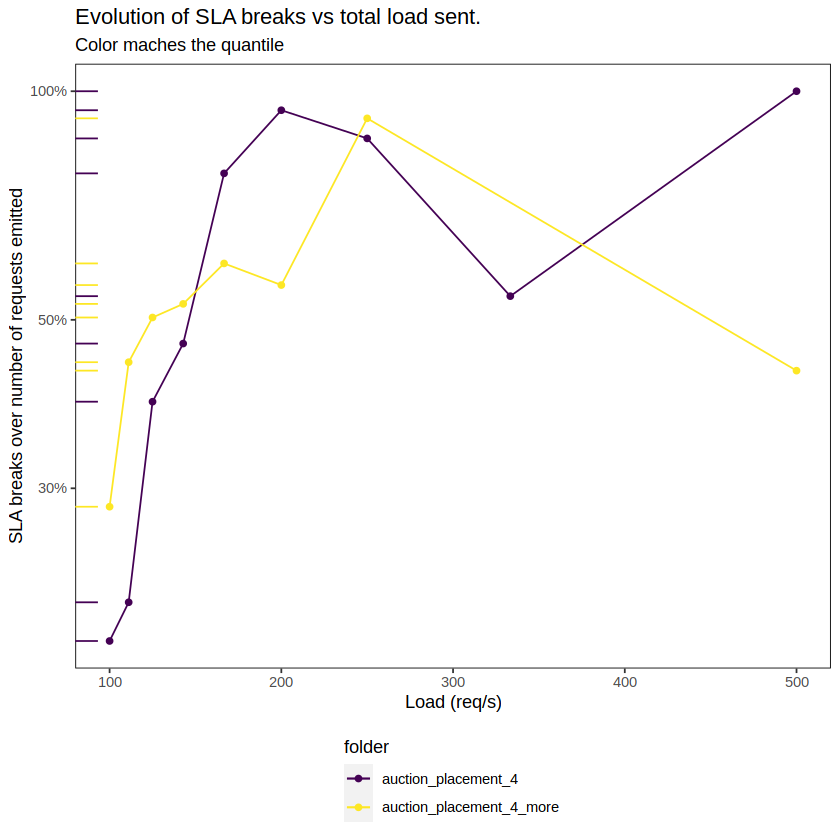

In [25]:
average_with_load %>%
select(load, break_sla, folder) %>%
group_by(load, folder) %>%
add_count() %>%
group_by(load, n, folder) %>%
summarize(broken = sum(break_sla, na.rm=TRUE), total = n()) %>%
mutate(percent = broken / n) %>%
drop_na() %>%
ggplot(
  aes(
    x = load,
    y = percent,
    color = folder,
  )
) +
geom_line() +
geom_point() +
geom_rug(sides="l") +
scale_y_continuous(trans = "log10", label=scales::percent)+
labs(
  x = "Load (req/s)",
  y = "SLA breaks over number of requests emitted",
  title = "Evolution of SLA breaks vs total load sent.",
  subtitle = paste("Color maches the quantile")
) +
# geom_texthline(data=latencies_plus_broken, aes(yintercept=as.numeric(latency)/1000, label = scales::percent(percent_broken)), colour="red",  vjust = 1.3, size = 3) +
# facet_grid(rows = vars(factor(latency, stringr::str_sort(unique(latency), numeric = TRUE)))) +
scale_color_viridis(discrete = TRUE, option = "D") +
scale_fill_viridis(discrete = TRUE) +
theme(
        legend.position='bottom',
        legend.direction='vertical',
    )

`summarise()` has grouped output by 'folder', 'load'. You can override using the `.groups` argument.
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


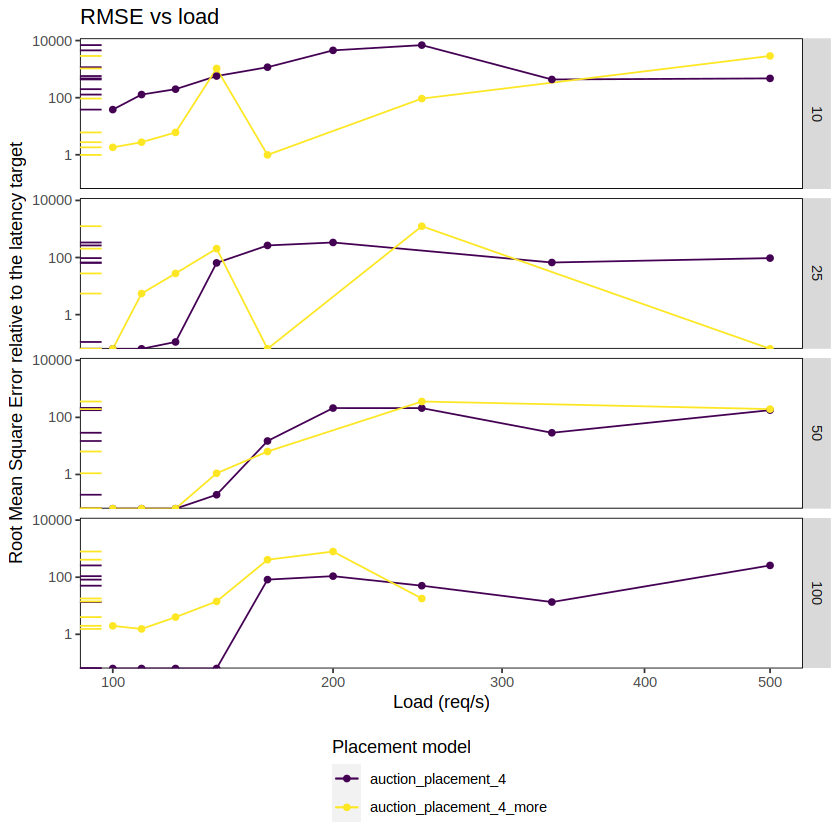

In [26]:
average_with_rmse <- average_with_load %>%
    mutate(latency_sec = as.numeric(latency) / 1000) %>%
    mutate(over_threshold = max(latency_sec, new_avg)) %>%
    group_by(folder, load, latency) %>%
    summarise(RMSE = rmse(over_threshold, latency_sec)) %>%
    mutate(RMSE_percent = RMSE/(as.numeric(latency)/1000)) %>%
    {.}

average_with_rmse %>%
ggplot(
  aes(
    x = load,
    y = RMSE_percent,
    color = folder,
  )
) +
geom_line() +
geom_point() +
scale_y_continuous(trans = "log10") + #, label = scales::percent) +
scale_x_continuous(trans = "sqrt") + #, label = scales::percent) +
geom_rug(sides="l") + 
facet_grid(rows = vars(factor(latency, stringr::str_sort(unique(latency), numeric = TRUE)))) +
labs(
  x = "Load (req/s)",
  y = "Root Mean Square Error relative to the latency target",
  title = "RMSE vs load",
  color = "Placement model") +
scale_color_viridis(discrete = TRUE, option = "D") +
scale_fill_viridis(discrete = TRUE) +
theme(
        legend.position='bottom',
        legend.direction='vertical',
    )

In [27]:
deployment_times_raw <-
  load_csv("market_function_deployment_time.csv") %>%
  prepare()

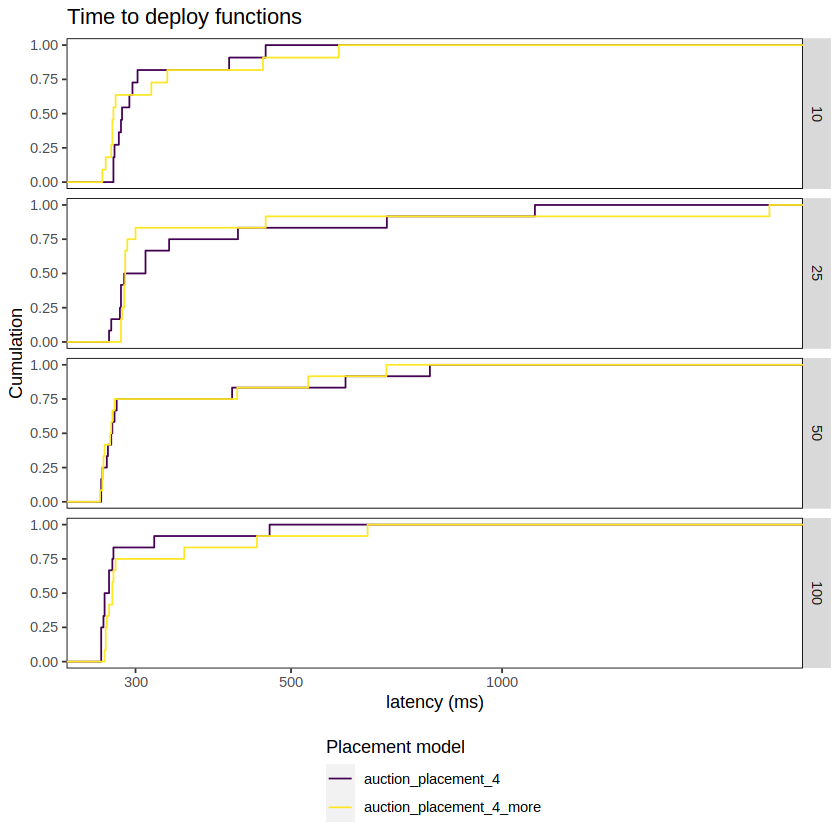

In [28]:
deployment_times <- deployment_times_raw %>%
    mutate(latency = stringr::str_match(function_name, "(.+)--(.+)--([0-9]+)--([0-9]+)--([0-9]+)") %>% .[,4]) %>%
    mutate(index = stringr::str_match(function_name, "(.+)--(.+)--([0-9]+)--([0-9]+)--([0-9]+)") %>% .[,3]) %>%
    select(function_name, folder, latency, value) %>%
    distinct() %>%
    drop_na() %>%
    {.}

# deployment_times

deployment_times %>%
ggplot(
  aes(
    x = value*1000,
    # y = value,
    color = folder,
  )
) +
stat_ecdf() +
scale_x_continuous(trans = "log10") +
facet_grid(rows = vars(factor(latency, stringr::str_sort(unique(latency), numeric = TRUE)))) +
labs(
  x = "latency (ms)",
  y = "Cumulation",
  title = "Time to deploy functions",
  color = "Placement model") +
scale_color_viridis(discrete = TRUE, option = "D") +
scale_fill_viridis(discrete = TRUE)